In [3]:
import os
import os.path
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from importlib import reload
import adaptive_confound.utils as acu
import adaptive_confound.control as acc
import adaptive_confound.topic_model as actm
import adaptive_confound.confound_detection as accd
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import pickle
import os.path
import tensorflow as tf
import itertools as it

pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 100

from datetime import datetime
from tqdm import tqdm
from sklearn import metrics, preprocessing
from sklearn.decomposition import PCA
from copy import deepcopy
from scipy.stats import mode
from collections import Counter, defaultdict
from tqdm import tqdm_notebook

from keras import backend as K
from keras.layers import Dense, Input, Lambda, Concatenate, Dropout
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.datasets import reuters
from keras.losses import binary_crossentropy, mse


In [5]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config=config)
set_session(sess)

In [6]:
sns.set(style="whitegrid")

In [7]:
d = acu.read_pickle("/data/virgile/confound/adaptive/in/twitter_dataset_y=location_z=gender.pkl")

In [8]:
d.create_biased_datasets(1000, [.1,.5,.9], k=1)

## Control for training/testing set in ABOW

In [9]:
abow = acc.A_BOW(d.features.size,
                 2,
                 hx=500, ht=200, hc=200,
                 use_last_epoch_model=False, checkpoint_dir="/data/virgile/checkpointing/nbs", use_ensemble_model=True,
                 n=11, p=.1, yz_weight_ratio=1, inv_factor=1,
                 optimizer="sgd", z_loss="categorical_crossentropy", z_activation="sigmoid")
#                  z_loss="binary_crossentropy", z_activation="sigmoid")

In [10]:
d_tr = d.biased_datasets[0]
d_te = d.biased_datasets[-1]
d_tr, d_te

(< Dataset: size=1000, p(y)=0.49, p(z)=0.49, bias=0.10, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None > >,
 < Dataset: size=1000, p(y)=0.51, p(z)=0.50, bias=0.90, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None > >)

In [ ]:
rpath = "abow_domain_adaptation.jsonl"
for d_tr, d_te in tqdm(list(it.product(d.iterate_biased_datasets("train"), d.iterate_biased_datasets("test")))):
    abow.fit_domain_adaptation(d_tr, d_te, 200)
    ypred = abow.label_clf.predict(d_te.X).round().flatten().astype(int)
    with open(rpath, "a") as fd:
        r = dict(
            tr_corr = d_tr.pearsonr[0],
            te_corr = d_te.pearsonr[0],
            ytrue = d_te.y.tolist(),
            ypred = ypred.tolist()
        )
        print(json.dumps(r), file=fd)

In [5]:
df = pd.read_json("./abow_domain_adaptation.jsonl", orient="records", lines=True)

In [6]:
df["f1"] = df.apply(lambda r: metrics.f1_score(r.ytrue, r.ypred), axis=1)
df["corr_diff"] = df.tr_corr - df.te_corr
df["corr_diff_round"] = df.corr_diff.round(1)
df.drop(["ypred", "ytrue"], axis=1, inplace=True)

In [7]:
df["model"] = "ABOW"

Run LR

In [8]:
from sklearn.linear_model import LogisticRegression

In [12]:
df.head()

,te_corr,tr_corr,f1,corr_diff,corr_diff_round,model
0,-0.822216,-0.776347,0.897087,0.045869,0.0,ABOW
1,-0.016131,-0.776347,0.740000,-0.760217,-0.8,ABOW
2,0.790019,-0.776347,0.668675,-1.566367,-1.6,ABOW
3,-0.822216,0.015811,0.712579,0.838027,0.8,ABOW
4,-0.016131,0.015811,0.883895,0.031942,0.0,ABOW


In [13]:
lr = LogisticRegression()
lr_results = []
for d_tr in tqdm(d.iterate_biased_datasets("train")):
    lr.fit(d_tr.X, d_tr.y)
    for d_te in tqdm(d.iterate_biased_datasets("test"), leave=False):
        ypred = lr.predict(d_te.X)
        lr_results.append(dict(
            te_corr = d_te.pearsonr[0],
            tr_corr = d_tr.pearsonr[0],
            model = "LR",
            corr_diff = d_tr.pearsonr[0] - d_te.pearsonr[0],
            corr_diff_round = np.around(d_tr.pearsonr[0] - d_te.pearsonr[0], 1),
            f1 = metrics.f1_score(d_te.y, ypred)
        ))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.07s/it]
0it [00:00, ?it/s]
2it [00:02,  1.10s/it]
0it [00:00, ?it/s]
3it [00:03,  1.07s/it]


In [18]:
lr_df = pd.DataFrame(lr_results)

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


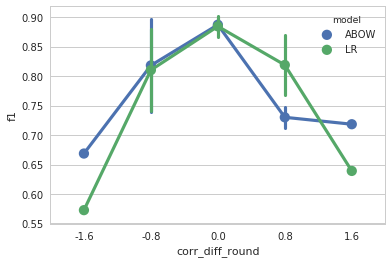

In [21]:
sns.pointplot("corr_diff_round", "f1", data=pd.concat([df, lr_df]), hue="model")

## Study word importance in ABOW for domain adaptation

Fit the A+BOW model for domain adaptation on a pair of datasets exhibiting high confounding shift.

In [748]:
abow = acc.A_BOW(d.features.size, 1,
                 hx=200, ht=50, hc=50,
                 use_last_epoch_model=False, checkpoint_dir="/data/virgile/checkpointing/nbs", use_ensemble_model=True,
                 n=11, p=.1, yz_weight_ratio=5, inv_factor=1,
                 optimizer="sgd", z_loss="binary_crossentropy", z_activation="sigmoid")
#                  z_loss="binary_crossentropy", z_activation="sigmoid")

TODO:

- tune L2 strength
- look at errors and analyze which units are to blame for which type of error (false positive, false negative)

In [749]:
n_epochs = 100
abow.fit_domain_adaptation(d_tr, d_te, n_epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/1
 - 1s - loss: 10.1831 - y_loss: 0.7639 - z_loss: 0.8430
Epoch 1/1
 - 1s - loss: 5.2373


  1%|          | 1/100 [00:02<04:00,  2.43s/it]

Epoch 1/1
 - 0s - loss: 8.9153 - y_loss: 0.6117 - z_loss: 0.4610
Epoch 1/1
 - 0s - loss: 5.0604


  2%|▏         | 2/100 [00:03<03:06,  1.90s/it]

Epoch 1/1
 - 0s - loss: 8.6750 - y_loss: 0.5747 - z_loss: 0.5231
Epoch 1/1
 - 0s - loss: 5.1411


  3%|▎         | 3/100 [00:03<02:25,  1.50s/it]

Epoch 1/1
 - 0s - loss: 8.0356 - y_loss: 0.4780 - z_loss: 0.4799
Epoch 1/1
 - 0s - loss: 4.9305


  4%|▍         | 4/100 [00:04<01:54,  1.19s/it]

Epoch 1/1
 - 0s - loss: 7.0557 - y_loss: 0.2927 - z_loss: 0.5356
Epoch 1/1
 - 0s - loss: 4.8197


  5%|▌         | 5/100 [00:04<01:32,  1.02it/s]

Epoch 1/1
 - 0s - loss: 7.3760 - y_loss: 0.3643 - z_loss: 0.6045
Epoch 1/1
 - 0s - loss: 4.8172


  6%|▌         | 6/100 [00:05<01:20,  1.16it/s]

Epoch 1/1
 - 0s - loss: 6.9796 - y_loss: 0.3038 - z_loss: 0.6148
Epoch 1/1
 - 0s - loss: 4.7222


  7%|▋         | 7/100 [00:05<01:13,  1.27it/s]

Epoch 1/1
 - 0s - loss: 5.7158 - y_loss: 0.0747 - z_loss: 0.6003
Epoch 1/1
 - 0s - loss: 4.5729


  8%|▊         | 8/100 [00:06<01:06,  1.38it/s]

Epoch 1/1
 - 0s - loss: 5.4564 - y_loss: 0.0461 - z_loss: 0.5890
Epoch 1/1
 - 0s - loss: 4.4784


  9%|▉         | 9/100 [00:06<01:02,  1.46it/s]

Epoch 1/1
 - 0s - loss: 5.3052 - y_loss: 0.0353 - z_loss: 0.5954
Epoch 1/1
 - 0s - loss: 4.3915


 10%|█         | 10/100 [00:07<00:59,  1.52it/s]

Epoch 1/1
 - 0s - loss: 5.1778 - y_loss: 0.0282 - z_loss: 0.6055
Epoch 1/1
 - 0s - loss: 4.3065


 11%|█         | 11/100 [00:08<00:58,  1.51it/s]

Epoch 1/1
 - 0s - loss: 5.0559 - y_loss: 0.0245 - z_loss: 0.6023
Epoch 1/1
 - 0s - loss: 4.2308


 12%|█▏        | 12/100 [00:08<00:57,  1.53it/s]

Epoch 1/1
 - 0s - loss: 4.9462 - y_loss: 0.0218 - z_loss: 0.6039
Epoch 1/1
 - 0s - loss: 4.1432


 13%|█▎        | 13/100 [00:09<00:53,  1.63it/s]

Epoch 1/1
 - 0s - loss: 4.8500 - y_loss: 0.0204 - z_loss: 0.6108
Epoch 1/1
 - 0s - loss: 4.0673


 14%|█▍        | 14/100 [00:09<00:51,  1.69it/s]

Epoch 1/1
 - 0s - loss: 4.7509 - y_loss: 0.0185 - z_loss: 0.6152
Epoch 1/1
 - 0s - loss: 3.9904


 15%|█▌        | 15/100 [00:10<00:50,  1.70it/s]

Epoch 1/1
 - 0s - loss: 4.6693 - y_loss: 0.0176 - z_loss: 0.6297
Epoch 1/1
 - 0s - loss: 3.9121


 16%|█▌        | 16/100 [00:11<00:47,  1.75it/s]

Epoch 1/1
 - 0s - loss: 4.5766 - y_loss: 0.0165 - z_loss: 0.6320
Epoch 1/1
 - 0s - loss: 3.8250


 17%|█▋        | 17/100 [00:11<00:46,  1.78it/s]

Epoch 1/1
 - 0s - loss: 4.4887 - y_loss: 0.0152 - z_loss: 0.6377
Epoch 1/1
 - 0s - loss: 3.7493


 18%|█▊        | 18/100 [00:12<00:46,  1.77it/s]

Epoch 1/1
 - 0s - loss: 4.3933 - y_loss: 0.0143 - z_loss: 0.6321
Epoch 1/1
 - 0s - loss: 3.6721


 19%|█▉        | 19/100 [00:12<00:45,  1.78it/s]

Epoch 1/1
 - 0s - loss: 4.3056 - y_loss: 0.0139 - z_loss: 0.6297
Epoch 1/1
 - 0s - loss: 3.5982


 20%|██        | 20/100 [00:13<00:45,  1.77it/s]

Epoch 1/1
 - 0s - loss: 4.2139 - y_loss: 0.0132 - z_loss: 0.6231
Epoch 1/1
 - 0s - loss: 3.5190


 21%|██        | 21/100 [00:13<00:44,  1.76it/s]

Epoch 1/1
 - 0s - loss: 4.1427 - y_loss: 0.0129 - z_loss: 0.6330
Epoch 1/1
 - 0s - loss: 3.4441


 22%|██▏       | 22/100 [00:14<00:44,  1.75it/s]

Epoch 1/1
 - 0s - loss: 4.0480 - y_loss: 0.0122 - z_loss: 0.6190
Epoch 1/1
 - 0s - loss: 3.3798


 23%|██▎       | 23/100 [00:15<00:45,  1.70it/s]

Epoch 1/1
 - 0s - loss: 3.9770 - y_loss: 0.0124 - z_loss: 0.6230
Epoch 1/1
 - 0s - loss: 3.3020


 24%|██▍       | 24/100 [00:15<00:45,  1.66it/s]

Epoch 1/1
 - 0s - loss: 3.8887 - y_loss: 0.0118 - z_loss: 0.6115
Epoch 1/1
 - 0s - loss: 3.2327


 25%|██▌       | 25/100 [00:16<00:45,  1.63it/s]

Epoch 1/1
 - 0s - loss: 3.8167 - y_loss: 0.0116 - z_loss: 0.6127
Epoch 1/1
 - 0s - loss: 3.1676


 26%|██▌       | 26/100 [00:16<00:44,  1.64it/s]

Epoch 1/1
 - 0s - loss: 3.7328 - y_loss: 0.0111 - z_loss: 0.6016
Epoch 1/1
 - 0s - loss: 3.1061


 27%|██▋       | 27/100 [00:17<00:43,  1.68it/s]

Epoch 1/1
 - 0s - loss: 3.6781 - y_loss: 0.0114 - z_loss: 0.6141
Epoch 1/1
 - 0s - loss: 3.0454


 28%|██▊       | 28/100 [00:18<00:42,  1.70it/s]

Epoch 1/1
 - 0s - loss: 3.6018 - y_loss: 0.0107 - z_loss: 0.6084
Epoch 1/1
 - 0s - loss: 2.9777


 29%|██▉       | 29/100 [00:18<00:41,  1.73it/s]

Epoch 1/1
 - 0s - loss: 3.5421 - y_loss: 0.0106 - z_loss: 0.6153
Epoch 1/1
 - 0s - loss: 2.9202


 30%|███       | 30/100 [00:19<00:41,  1.68it/s]

Epoch 1/1
 - 0s - loss: 3.4778 - y_loss: 0.0106 - z_loss: 0.6148
Epoch 1/1
 - 0s - loss: 2.8537


 31%|███       | 31/100 [00:19<00:40,  1.72it/s]

Epoch 1/1
 - 0s - loss: 3.4229 - y_loss: 0.0103 - z_loss: 0.6242
Epoch 1/1
 - 0s - loss: 2.8020


 32%|███▏      | 32/100 [00:20<00:40,  1.67it/s]

Epoch 1/1
 - 0s - loss: 3.3488 - y_loss: 0.0103 - z_loss: 0.6113
Epoch 1/1
 - 0s - loss: 2.7550


 33%|███▎      | 33/100 [00:21<00:39,  1.70it/s]

Epoch 1/1
 - 0s - loss: 3.2922 - y_loss: 0.0101 - z_loss: 0.6154
Epoch 1/1
 - 0s - loss: 2.7075


 34%|███▍      | 34/100 [00:21<00:37,  1.75it/s]

Epoch 1/1
 - 0s - loss: 3.2222 - y_loss: 0.0102 - z_loss: 0.6035
Epoch 1/1
 - 0s - loss: 2.6567


 35%|███▌      | 35/100 [00:22<00:37,  1.75it/s]

Epoch 1/1
 - 0s - loss: 3.1788 - y_loss: 0.0100 - z_loss: 0.6181
Epoch 1/1
 - 0s - loss: 2.6072


 36%|███▌      | 36/100 [00:22<00:35,  1.82it/s]

Epoch 1/1
 - 0s - loss: 3.1292 - y_loss: 0.0098 - z_loss: 0.6249
Epoch 1/1
 - 0s - loss: 2.5550


 37%|███▋      | 37/100 [00:23<00:34,  1.84it/s]

Epoch 1/1
 - 0s - loss: 3.0811 - y_loss: 0.0097 - z_loss: 0.6319
Epoch 1/1
 - 0s - loss: 2.5210


 38%|███▊      | 38/100 [00:23<00:33,  1.86it/s]

Epoch 1/1
 - 0s - loss: 3.0386 - y_loss: 0.0094 - z_loss: 0.6436
Epoch 1/1
 - 0s - loss: 2.4698


 39%|███▉      | 39/100 [00:24<00:33,  1.85it/s]

Epoch 1/1
 - 0s - loss: 2.9959 - y_loss: 0.0096 - z_loss: 0.6517
Epoch 1/1
 - 0s - loss: 2.4381


 40%|████      | 40/100 [00:24<00:33,  1.82it/s]

Epoch 1/1
 - 0s - loss: 2.9444 - y_loss: 0.0094 - z_loss: 0.6519
Epoch 1/1
 - 0s - loss: 2.3921


 41%|████      | 41/100 [00:25<00:33,  1.79it/s]

Epoch 1/1
 - 0s - loss: 2.9064 - y_loss: 0.0092 - z_loss: 0.6644
Epoch 1/1
 - 0s - loss: 2.3546


 42%|████▏     | 42/100 [00:25<00:31,  1.83it/s]

Epoch 1/1
 - 0s - loss: 2.8618 - y_loss: 0.0095 - z_loss: 0.6667
Epoch 1/1
 - 0s - loss: 2.3221


 43%|████▎     | 43/100 [00:26<00:30,  1.89it/s]

Epoch 1/1
 - 0s - loss: 2.8219 - y_loss: 0.0092 - z_loss: 0.6753
Epoch 1/1
 - 0s - loss: 2.2832


 44%|████▍     | 44/100 [00:26<00:30,  1.83it/s]

Epoch 1/1
 - 0s - loss: 2.7729 - y_loss: 0.0093 - z_loss: 0.6715
Epoch 1/1
 - 0s - loss: 2.2493


 45%|████▌     | 45/100 [00:27<00:30,  1.81it/s]

Epoch 1/1
 - 0s - loss: 2.7392 - y_loss: 0.0091 - z_loss: 0.6842
Epoch 1/1
 - 0s - loss: 2.2127


 46%|████▌     | 46/100 [00:28<00:29,  1.80it/s]

Epoch 1/1
 - 0s - loss: 2.6981 - y_loss: 0.0092 - z_loss: 0.6864
Epoch 1/1
 - 0s - loss: 2.1782


 47%|████▋     | 47/100 [00:28<00:29,  1.79it/s]

Epoch 1/1
 - 0s - loss: 2.6526 - y_loss: 0.0092 - z_loss: 0.6840
Epoch 1/1
 - 0s - loss: 2.1416


 48%|████▊     | 48/100 [00:29<00:28,  1.80it/s]

Epoch 1/1
 - 0s - loss: 2.6121 - y_loss: 0.0089 - z_loss: 0.6866
Epoch 1/1
 - 0s - loss: 2.1031


 49%|████▉     | 49/100 [00:29<00:28,  1.80it/s]

Epoch 1/1
 - 0s - loss: 2.5587 - y_loss: 0.0091 - z_loss: 0.6735
Epoch 1/1
 - 0s - loss: 2.0715


 50%|█████     | 50/100 [00:30<00:28,  1.77it/s]

Epoch 1/1
 - 0s - loss: 2.5240 - y_loss: 0.0090 - z_loss: 0.6787
Epoch 1/1
 - 0s - loss: 2.0326


 51%|█████     | 51/100 [00:30<00:27,  1.77it/s]

Epoch 1/1
 - 0s - loss: 2.4646 - y_loss: 0.0091 - z_loss: 0.6583
Epoch 1/1
 - 0s - loss: 2.0072


 52%|█████▏    | 52/100 [00:31<00:27,  1.71it/s]

Epoch 1/1
 - 0s - loss: 2.4383 - y_loss: 0.0091 - z_loss: 0.6696
Epoch 1/1
 - 0s - loss: 1.9704


 53%|█████▎    | 53/100 [00:32<00:28,  1.67it/s]

Epoch 1/1
 - 0s - loss: 2.4003 - y_loss: 0.0092 - z_loss: 0.6685
Epoch 1/1
 - 0s - loss: 1.9374


 54%|█████▍    | 54/100 [00:32<00:27,  1.65it/s]

Epoch 1/1
 - 0s - loss: 2.3508 - y_loss: 0.0091 - z_loss: 0.6555
Epoch 1/1
 - 0s - loss: 1.9093


 55%|█████▌    | 55/100 [00:33<00:26,  1.67it/s]

Epoch 1/1
 - 0s - loss: 2.3206 - y_loss: 0.0090 - z_loss: 0.6613
Epoch 1/1
 - 0s - loss: 1.8761


 56%|█████▌    | 56/100 [00:33<00:25,  1.70it/s]

Epoch 1/1
 - 0s - loss: 2.2506 - y_loss: 0.0090 - z_loss: 0.6257
Epoch 1/1
 - 0s - loss: 1.8611


 57%|█████▋    | 57/100 [00:34<00:23,  1.81it/s]

Epoch 1/1
 - 0s - loss: 35.5275 - y_loss: 6.7492 - z_loss: 0.2127
Epoch 1/1
 - 0s - loss: 1.6478


 58%|█████▊    | 58/100 [00:34<00:23,  1.82it/s]

Epoch 1/1
 - 0s - loss: 4.8139 - y_loss: 0.5123 - z_loss: 0.7326
Epoch 1/1
 - 0s - loss: 1.8525


 59%|█████▉    | 59/100 [00:35<00:22,  1.80it/s]

Epoch 1/1
 - 0s - loss: 3.8265 - y_loss: 0.3224 - z_loss: 0.7155
Epoch 1/1
 - 0s - loss: 1.7604


 60%|██████    | 60/100 [00:36<00:21,  1.82it/s]

Epoch 1/1
 - 0s - loss: 4.0779 - y_loss: 0.3909 - z_loss: 0.6448
Epoch 1/1
 - 0s - loss: 1.7709


 61%|██████    | 61/100 [00:36<00:21,  1.83it/s]

Epoch 1/1
 - 0s - loss: 3.1769 - y_loss: 0.2236 - z_loss: 0.6004
Epoch 1/1
 - 0s - loss: 1.7360


 62%|██████▏   | 62/100 [00:37<00:20,  1.81it/s]

Epoch 1/1
 - 0s - loss: 2.3682 - y_loss: 0.0688 - z_loss: 0.5887
Epoch 1/1
 - 0s - loss: 1.7737


 63%|██████▎   | 63/100 [00:37<00:19,  1.88it/s]

Epoch 1/1
 - 0s - loss: 2.1737 - y_loss: 0.0319 - z_loss: 0.6052
Epoch 1/1
 - 0s - loss: 1.6540


 64%|██████▍   | 64/100 [00:38<00:18,  1.95it/s]

Epoch 1/1
 - 0s - loss: 2.0892 - y_loss: 0.0253 - z_loss: 0.5809
Epoch 1/1
 - 0s - loss: 1.6181


 65%|██████▌   | 65/100 [00:38<00:18,  1.90it/s]

Epoch 1/1
 - 0s - loss: 4.7065 - y_loss: 0.5405 - z_loss: 0.6452
Epoch 1/1
 - 0s - loss: 1.6047


 66%|██████▌   | 66/100 [00:39<00:18,  1.85it/s]

Epoch 1/1
 - 0s - loss: 2.6400 - y_loss: 0.1028 - z_loss: 0.7911
Epoch 1/1
 - 0s - loss: 1.6204


 67%|██████▋   | 67/100 [00:39<00:18,  1.77it/s]

Epoch 1/1
 - 0s - loss: 3.9470 - y_loss: 0.3847 - z_loss: 0.7084
Epoch 1/1
 - 0s - loss: 1.5253


 68%|██████▊   | 68/100 [00:40<00:18,  1.74it/s]

Epoch 1/1
 - 0s - loss: 2.0698 - y_loss: 0.0310 - z_loss: 0.6232
Epoch 1/1
 - 0s - loss: 1.5303


 69%|██████▉   | 69/100 [00:41<00:18,  1.71it/s]

Epoch 1/1
 - 0s - loss: 1.9074 - y_loss: 0.0233 - z_loss: 0.5247
Epoch 1/1
 - 0s - loss: 1.4797


 70%|███████   | 70/100 [00:41<00:17,  1.75it/s]

Epoch 1/1
 - 0s - loss: 1.9039 - y_loss: 0.0206 - z_loss: 0.5592
Epoch 1/1
 - 0s - loss: 1.4538


 71%|███████   | 71/100 [00:42<00:16,  1.75it/s]

Epoch 1/1
 - 0s - loss: 1.8161 - y_loss: 0.0190 - z_loss: 0.5037
Epoch 1/1
 - 0s - loss: 1.3946


 72%|███████▏  | 72/100 [00:42<00:15,  1.78it/s]

Epoch 1/1
 - 0s - loss: 1.7699 - y_loss: 0.0174 - z_loss: 0.4894
Epoch 1/1
 - 0s - loss: 1.3701


 73%|███████▎  | 73/100 [00:43<00:14,  1.85it/s]

Epoch 1/1
 - 0s - loss: 3.4337 - y_loss: 0.3554 - z_loss: 0.4810
Epoch 1/1
 - 0s - loss: 1.3499


 74%|███████▍  | 74/100 [00:43<00:14,  1.85it/s]

Epoch 1/1
 - 0s - loss: 1.7480 - y_loss: 0.0189 - z_loss: 0.4998
Epoch 1/1
 - 0s - loss: 1.3565


 75%|███████▌  | 75/100 [00:44<00:13,  1.83it/s]

Epoch 1/1
 - 0s - loss: 3.1551 - y_loss: 0.2903 - z_loss: 0.5682
Epoch 1/1
 - 0s - loss: 1.2549


 76%|███████▌  | 76/100 [00:44<00:13,  1.78it/s]

Epoch 1/1
 - 0s - loss: 2.4680 - y_loss: 0.1461 - z_loss: 0.6189
Epoch 1/1
 - 0s - loss: 1.4145


 77%|███████▋  | 77/100 [00:45<00:12,  1.80it/s]

Epoch 1/1
 - 0s - loss: 2.2005 - y_loss: 0.0796 - z_loss: 0.7027
Epoch 1/1
 - 0s - loss: 1.2540


 78%|███████▊  | 78/100 [00:46<00:12,  1.81it/s]

Epoch 1/1
 - 0s - loss: 2.6700 - y_loss: 0.1976 - z_loss: 0.6002
Epoch 1/1
 - 0s - loss: 1.3306


 79%|███████▉  | 79/100 [00:46<00:12,  1.73it/s]

Epoch 1/1
 - 0s - loss: 1.8846 - y_loss: 0.0365 - z_loss: 0.6386
Epoch 1/1
 - 0s - loss: 1.1963


 80%|████████  | 80/100 [00:47<00:11,  1.71it/s]

Epoch 1/1
 - 0s - loss: 3.3397 - y_loss: 0.3590 - z_loss: 0.4918
Epoch 1/1
 - 0s - loss: 1.4976


 81%|████████  | 81/100 [00:47<00:11,  1.70it/s]

Epoch 1/1
 - 0s - loss: 1.8206 - y_loss: 0.0453 - z_loss: 0.5555
Epoch 1/1
 - 0s - loss: 1.4519


 82%|████████▏ | 82/100 [00:48<00:10,  1.71it/s]

Epoch 1/1
 - 0s - loss: 2.6239 - y_loss: 0.2187 - z_loss: 0.5071
Epoch 1/1
 - 0s - loss: 1.3237


 83%|████████▎ | 83/100 [00:49<00:10,  1.69it/s]

Epoch 1/1
 - 0s - loss: 1.7345 - y_loss: 0.0292 - z_loss: 0.5828
Epoch 1/1
 - 0s - loss: 1.3350


 84%|████████▍ | 84/100 [00:49<00:09,  1.73it/s]

Epoch 1/1
 - 0s - loss: 1.6897 - y_loss: 0.0222 - z_loss: 0.5909
Epoch 1/1
 - 0s - loss: 1.2301


 85%|████████▌ | 85/100 [00:50<00:08,  1.76it/s]

Epoch 1/1
 - 0s - loss: 1.6014 - y_loss: 0.0153 - z_loss: 0.5559
Epoch 1/1
 - 0s - loss: 1.3091


 86%|████████▌ | 86/100 [00:50<00:08,  1.73it/s]

Epoch 1/1
 - 0s - loss: 1.9789 - y_loss: 0.0739 - z_loss: 0.6563
Epoch 1/1
 - 0s - loss: 1.1772


 87%|████████▋ | 87/100 [00:51<00:07,  1.79it/s]

Epoch 1/1
 - 0s - loss: 1.5937 - y_loss: 0.0163 - z_loss: 0.5767
Epoch 1/1
 - 0s - loss: 1.2941


 88%|████████▊ | 88/100 [00:51<00:06,  1.82it/s]

Epoch 1/1
 - 0s - loss: 2.3350 - y_loss: 0.1445 - z_loss: 0.6912
Epoch 1/1
 - 0s - loss: 1.1429


 89%|████████▉ | 89/100 [00:52<00:06,  1.75it/s]

Epoch 1/1
 - 0s - loss: 1.5942 - y_loss: 0.0243 - z_loss: 0.5668
Epoch 1/1
 - 0s - loss: 1.2313


 90%|█████████ | 90/100 [00:52<00:05,  1.72it/s]

Epoch 1/1
 - 0s - loss: 1.8752 - y_loss: 0.0713 - z_loss: 0.6256
Epoch 1/1
 - 0s - loss: 1.1761


 91%|█████████ | 91/100 [00:53<00:05,  1.67it/s]

Epoch 1/1
 - 0s - loss: 1.4989 - y_loss: 0.0145 - z_loss: 0.5497
Epoch 1/1
 - 0s - loss: 1.1701


 92%|█████████▏| 92/100 [00:54<00:04,  1.73it/s]

Epoch 1/1
 - 0s - loss: 1.4780 - y_loss: 0.0141 - z_loss: 0.5474
Epoch 1/1
 - 0s - loss: 1.1532


 93%|█████████▎| 93/100 [00:54<00:03,  1.78it/s]

Epoch 1/1
 - 0s - loss: 1.4145 - y_loss: 0.0121 - z_loss: 0.5097
Epoch 1/1
 - 0s - loss: 1.1147


 94%|█████████▍| 94/100 [00:55<00:03,  1.85it/s]

Epoch 1/1
 - 0s - loss: 1.4174 - y_loss: 0.0124 - z_loss: 0.5269
Epoch 1/1
 - 0s - loss: 1.1060


 95%|█████████▌| 95/100 [00:55<00:02,  1.83it/s]

Epoch 1/1
 - 0s - loss: 1.4141 - y_loss: 0.0124 - z_loss: 0.5390
Epoch 1/1
 - 0s - loss: 1.0992


 96%|█████████▌| 96/100 [00:56<00:02,  1.81it/s]

Epoch 1/1
 - 0s - loss: 1.3458 - y_loss: 0.0110 - z_loss: 0.4931
Epoch 1/1
 - 0s - loss: 1.0730


 97%|█████████▋| 97/100 [00:56<00:01,  1.76it/s]

Epoch 1/1
 - 0s - loss: 2.5317 - y_loss: 0.2452 - z_loss: 0.5197
Epoch 1/1
 - 0s - loss: 1.1043


 98%|█████████▊| 98/100 [00:57<00:01,  1.73it/s]

Epoch 1/1
 - 0s - loss: 1.3840 - y_loss: 0.0143 - z_loss: 0.5408
Epoch 1/1
 - 0s - loss: 1.0772


 99%|█████████▉| 99/100 [00:58<00:00,  1.66it/s]

Epoch 1/1
 - 0s - loss: 3.8196 - y_loss: 0.5114 - z_loss: 0.4928
Epoch 1/1
 - 0s - loss: 1.1128


In [750]:
f1s, precs, recs = [], [], []
for i in tqdm(range(n_epochs)):
    mpath = abow.cpt_name.format(epoch=i)
    abow.model.load_weights(mpath)
    ypred = abow.label_clf.predict(d_te.X).round().astype(int).flatten()
    f1s.append(metrics.f1_score(d_te.y, ypred))
    precs.append(metrics.precision_score(d_te.y, ypred))
    recs.append(metrics.recall_score(d_te.y, ypred))

100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


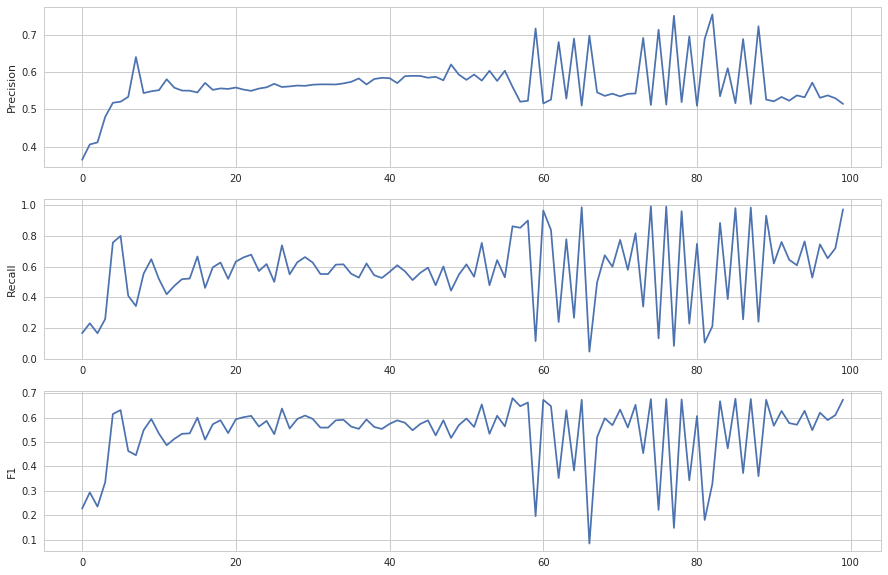

In [753]:
fig, ax = plt.subplots(3, figsize=(15,10))
ax[0].plot(precs)
ax[0].set_ylabel("Precision")
ax[1].plot(recs)
ax[1].set_ylabel("Recall")
ax[2].plot(f1s)
ax[2].set_ylabel("F1");

In [817]:
d.features[d_tr.X[d_tr.y == 1].sum(axis=0).A1.argsort()[::-1]]

array(['summer', 'excited', 'thought', ..., 'e32015', 'bruin', 'safeway'],
      dtype='<U32')

In [757]:
i = 60 #np.argmax(f1s)
print(f1s[i], precs[i], recs[i])
abow.model.load_weights(abow.cpt_name.format(epoch=i))
zws = abow.domain_clf.get_weights()[::2]
zbs = abow.domain_clf.get_weights()[1::2]

0.6721536351165982 0.5157894736842106 0.9645669291338582


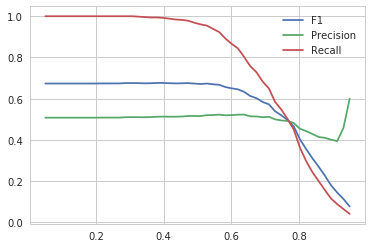

In [807]:
y_proba = abow.label_clf.predict(d_te.X)
x_plot = []
f1_plot, prec_plot, rec_plot = [], [], []
for thresh in np.linspace(.05, .95, 50):
    y_pred = (y_proba > thresh).round().astype(int).flatten()
    x_plot.append(thresh)
    f1_plot.append(metrics.f1_score(d_te.y, y_pred))
    prec_plot.append(metrics.precision_score(d_te.y, y_pred))
    rec_plot.append(metrics.recall_score(d_te.y, y_pred))
    
plt.plot(x_plot, f1_plot, label="F1")
plt.plot(x_plot, prec_plot, label="Precision")
plt.plot(x_plot, rec_plot, label="Recall")
plt.legend()

In [758]:
yws = abow.label_clf.get_weights()[::2]
ybs = abow.label_clf.get_weights()[1::2]

Compute the activation value of each hidden unit in the network for documents with a unique word.

In [759]:
yws = abow.label_clf.get_weights()[::2]
ybs = abow.label_clf.get_weights()[1::2]

def get_unit_distrib(inp, weights, biases):
    x = inp
    for w, b in zip(weights[:-1], biases[:-1]):
        x = x.dot(w) + b
    l = weights[-1].T
    if l.shape[0] > 1:
        x = np.stack([x * l[i] for i in l.shape[0]], axis=0)
    else:
        x = x * l
    return x

In [760]:
k = 21982
uniq_words = np.eye(21981)[:k]
words = d.features[:k]
z_hidden_unit_distrib = get_unit_distrib(uniq_words, zws, zbs)
y_hidden_unit_distrib = get_unit_distrib(uniq_words, yws, ybs)

Plot an example with words correlated strongly with y, z, or both.

In [811]:
keep_words = ["nyc", "ny", "nj", "la", "angeles", "california", "jokes", "cookout"]
hist_keep_words = z_hidden_unit_distrib[np.hstack([
    np.where(d.features == _) for _ in keep_words
])[0]]

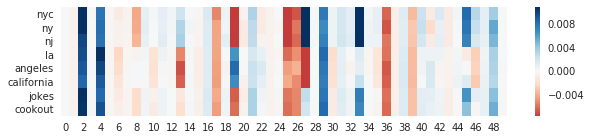

In [812]:
fig, ax = plt.subplots(figsize=(10, 2))#int(.1*hidden_unit_distrib.shape[0])))
sns.heatmap(hist_keep_words, robust=True, center=0, ax=ax, cmap="RdBu",
            yticklabels=keep_words)
fig.savefig("hidden_unit_per_word.png", box_inches="tight")

Cluster the words given the activation values of the hidden units

In [766]:
from sklearn.cluster import KMeans

In [768]:
%%time
kmeans = KMeans(n_clusters=10)
y_clusters_kmeans = kmeans.fit_predict(y_hidden_unit_distrib)
y_scores_kmeans = kmeans.transform(y_hidden_unit_distrib)
z_clusters_kmeans = kmeans.fit_predict(z_hidden_unit_distrib)
z_scores_kmeans = kmeans.transform(z_hidden_unit_distrib)

CPU times: user 8.22 s, sys: 14.9 s, total: 23.1 s
Wall time: 6.96 s


In [769]:
def print_clusters(clusters, scores, features):
    plt.hist(clusters);
    for c in np.unique(clusters):
        print("Cluster {:d}".format(c))
        in_c = np.where(clusters == c)[0]
        c_scores = scores[in_c, c]
        
        sort_idx_low = c_scores.argsort()[:30]
        sort_idx_high = c_scores.argsort()[::-1][:30]
        
        low_fts = features[in_c][sort_idx_low]
        low_scores = c_scores[sort_idx_low]
        high_fts = features[in_c][sort_idx_high]
        high_scores = c_scores[sort_idx_high]
        
        for lf, ls, hf, hs in zip(low_fts, low_scores, high_fts, high_scores):
            print("\t- {:.<25} {:5f}\t {:.<25} {:5f}".format(lf, ls, hf, hs))

In [770]:
def plot_pca(X_pca, clusters, features):
    fig, ax = plt.subplots(figsize=(15,15))
    colors = sns.color_palette(palette="muted", n_colors=10)
    # sns.palettes.diverging_palette(0, 180, n=10)
    markers = ["x", "s", "o", "v"]
    for i, c in enumerate(np.unique(clusters)):
        in_c = clusters == c
        pca0, pca1 = X_pca[in_c,0], X_pca[in_c,1]
        ax.scatter(pca0, pca1, c=colors[i], marker=markers[i % len(markers)],
                   alpha=.3, label="Cluster {}".format(i))
        pca0mi, pca0Mi = pca0.argmin(), pca0.argmax()
        pca1mi, pca1Mi = pca1.argmin(), pca1.argmax()
        pca_fts = features[in_c]
        for pca_idx in [pca0mi, pca0Mi, pca1mi, pca1Mi]:
            ax.annotate(pca_fts[pca_idx], (pca0[pca_idx], pca1[pca_idx]))
    plt.legend()
    return fig, ax

Clusters for hidden layer before y prediction

Cluster 0
	- republicans.............. 0.003939	 missed................... 0.010577
	- adapt.................... 0.004046	 groom.................... 0.010462
	- angelic.................. 0.004114	 acct..................... 0.010093
	- marked................... 0.004130	 sunglasses............... 0.010044
	- rates.................... 0.004170	 thinking................. 0.009917
	- theworldstories.......... 0.004190	 accurately............... 0.009814
	- colored.................. 0.004249	 string................... 0.009803
	- stereotype............... 0.004281	 factsionary.............. 0.009710
	- gilt..................... 0.004313	 response................. 0.009707
	- espn2.................... 0.004317	 thetumblrposts........... 0.009705
	- ebertchicago............. 0.004345	 michaelianblack.......... 0.009704
	- breeze................... 0.004347	 luv...................... 0.009586
	- extraordinaire........... 0.004357	 spilled.................. 0.009584
	- mortal...................

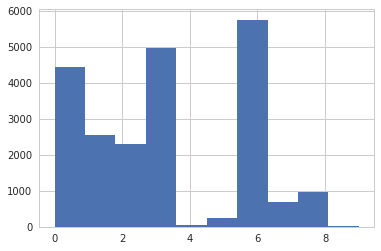

In [771]:
print_clusters(y_clusters_kmeans, y_scores_kmeans, d.features)

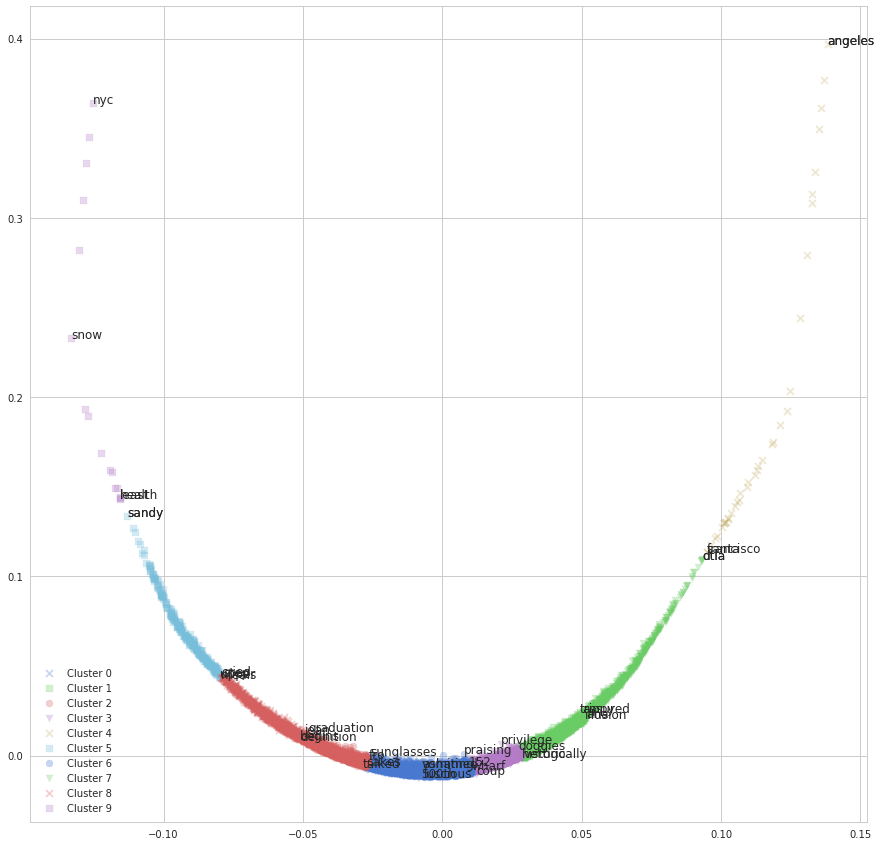

In [772]:
pca = PCA(2)
X_pca = pca.fit_transform(y_scores_kmeans)

fig, ax = plot_pca(X_pca, y_clusters_kmeans, d.features)
fig.savefig("cluster_pca_one_word.png")

Clusters for hidden layer before z prediction

Cluster 0
	- ungrateful............... 0.001164	 http..................... 0.004615
	- reportedly............... 0.001242	 clarity.................. 0.004032
	- guggenheim............... 0.001248	 thought.................. 0.003859
	- regal.................... 0.001306	 proud.................... 0.003649
	- drained.................. 0.001309	 body..................... 0.003634
	- bynes.................... 0.001315	 precious................. 0.003613
	- ofcourse................. 0.001326	 dollars.................. 0.003609
	- clifton.................. 0.001336	 roommate................. 0.003585
	- bartender................ 0.001344	 sophisticated............ 0.003548
	- shoes.................... 0.001380	 twerk.................... 0.003530
	- amaze.................... 0.001381	 webster.................. 0.003512
	- terms.................... 0.001382	 latergram................ 0.003509
	- jacobs................... 0.001392	 honey.................... 0.003489
	- shoppers.................

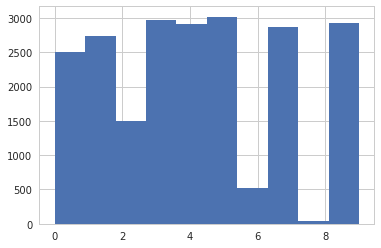

In [773]:
print_clusters(z_clusters_kmeans, z_scores_kmeans, d.features)

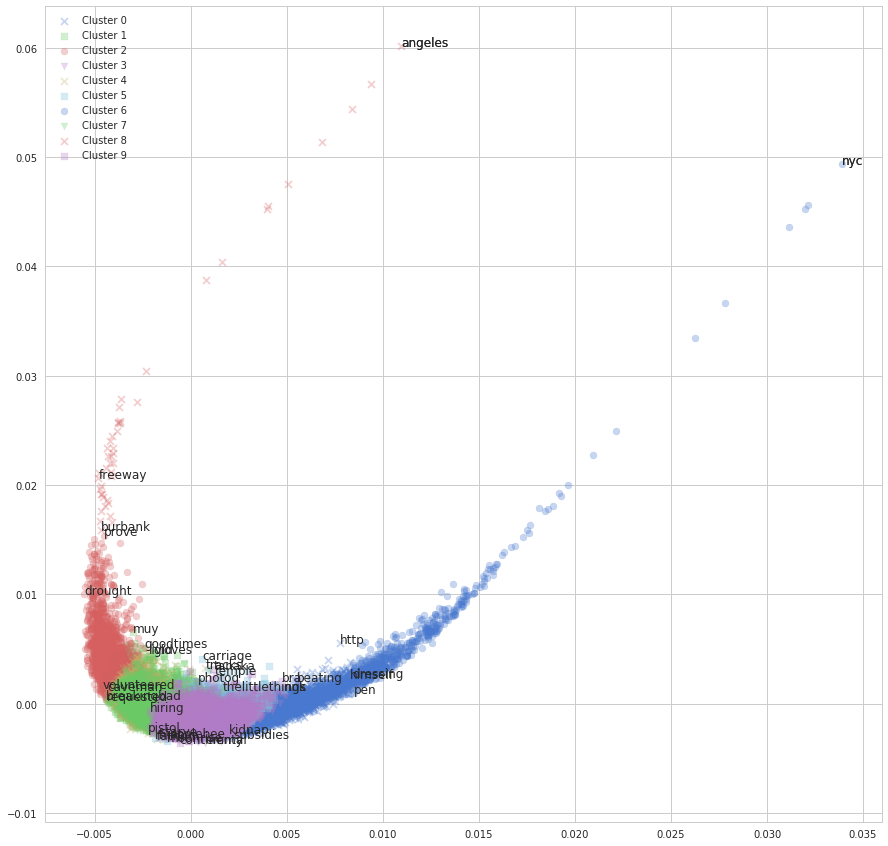

In [774]:
pca = PCA(2)
X_pca = pca.fit_transform(z_scores_kmeans)

fig, ax = plot_pca(X_pca, z_clusters_kmeans, d.features)
fig.savefig("cluster_pca_one_word_z.png")

Stack representation from z hidden layer and y hidden layer and cluster this representation

In [775]:
all_unit_distrib = np.hstack([ z_hidden_unit_distrib, y_hidden_unit_distrib ])

In [776]:
all_clusters_kmeans = kmeans.fit_predict(all_unit_distrib)
all_scores_kmeans = kmeans.transform(all_unit_distrib)

Cluster 0
	- marked................... 0.004419	 missed................... 0.011077
	- stereotype............... 0.004442	 groom.................... 0.010933
	- republicans.............. 0.004449	 spilled.................. 0.010190
	- childish................. 0.004550	 thinking................. 0.010183
	- upp...................... 0.004630	 7c....................... 0.010163
	- espn2.................... 0.004670	 michaelianblack.......... 0.010118
	- dunno.................... 0.004713	 columns.................. 0.010106
	- angelic.................. 0.004759	 thetumblrposts........... 0.010073
	- halls.................... 0.004762	 lori..................... 0.010047
	- deliberate............... 0.004778	 sunglasses............... 0.009957
	- rates.................... 0.004787	 unfamiliar............... 0.009953
	- sexiness................. 0.004803	 hahaa.................... 0.009929
	- revis.................... 0.004824	 blurry................... 0.009927
	- adapt....................

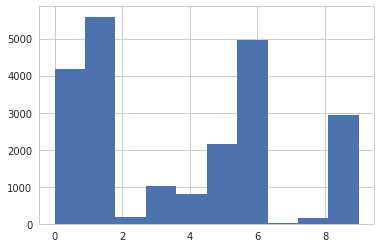

In [777]:
print_clusters(all_clusters_kmeans, all_scores_kmeans, d.features)

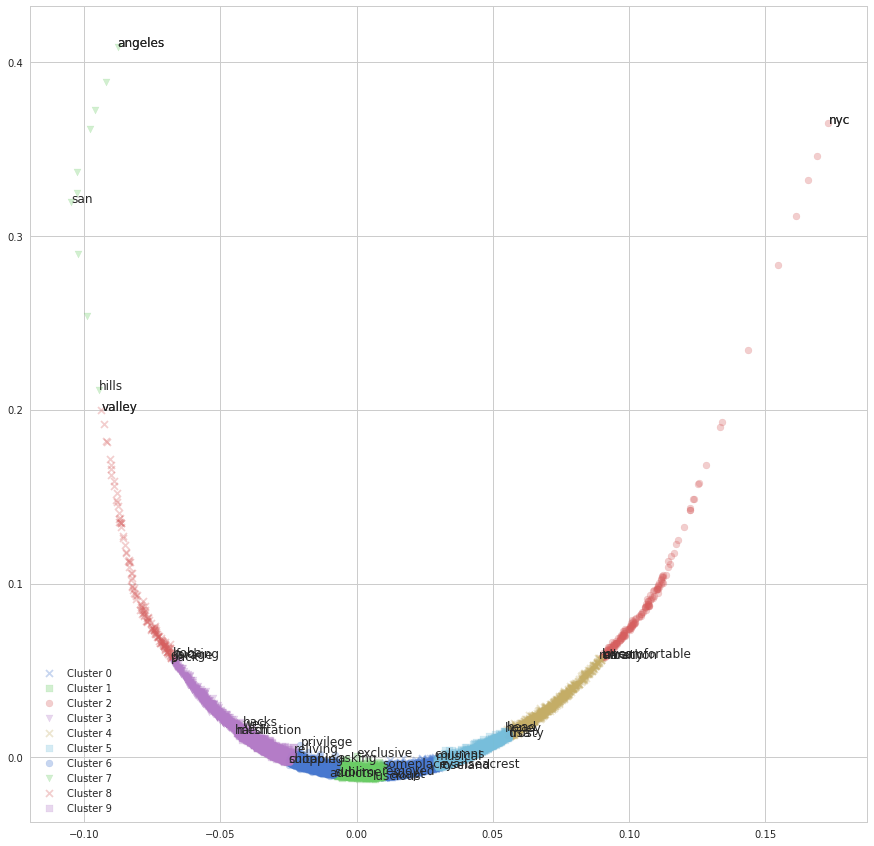

In [778]:
pca = PCA(2)
X_pca = pca.fit_transform(all_scores_kmeans)

fig, ax = plot_pca(X_pca, all_clusters_kmeans, d.features)
fig.savefig("cluster_pca_one_word_concat.png")

Same process for pairs of words

In [503]:
from scipy.stats import pearsonr

Select words that are highly correlated with y or z and choose a set of random words.

In [504]:
k_words = 250
top_y_corr_idx = np.abs(y_corr).argsort()[::-1][:k_words]
top_z_corr_idx = np.abs(z_corr).argsort()[::-1][:k_words]
random_words = np.random.choice(range(d.features.size), size=k_words*2, replace=False)

Compute all pairs of words using the previously selected words and build a sparse matrix where one document contains only two words.

In [505]:
all_words = np.array(list( set(top_y_corr_idx) | set(top_z_corr_idx) | set(random_words) ))

In [506]:
all_pairs = list(it.combinations(all_words, 2))

In [507]:
data, row_ind, col_ind, pair_vocab = [], [], [], []
for i, (w1, w2) in enumerate(all_pairs):
    data.extend([1, 1])
    row_ind.extend([i, i])
    col_ind.extend([w1, w2])
    pair_vocab.append("+".join(d.features[[w1, w2]]))

In [508]:
X_pair = sp.csr_matrix((data, (row_ind, col_ind)), shape=(len(all_pairs), d.features.size))

In [509]:
X_pair.shape

(484620, 21981)

In [511]:
hidden_unit_distrib_pair = get_unit_distrib(X_pair, ws, bs)

In [513]:
%%time
kmeans = KMeans(n_clusters=10)
all_hidden_unit_distrib = np.vstack([hidden_unit_distrib[1], hidden_unit_distrib_pair[1]])
clusters_kmeans_pair = kmeans.fit_predict(all_hidden_unit_distrib)
scores_kmeans_pair = kmeans.transform(all_hidden_unit_distrib)

CPU times: user 6min 44s, sys: 31 s, total: 7min 15s
Wall time: 6min 7s


In [514]:
vocabulary = np.hstack( [ d.features, pair_vocab ] )

Cluster 0
	- snooki................... 0.000636	 warfare+heels............ 0.001566
	- defensive................ 0.000646	 pink+scoring............. 0.001557
	- mat...................... 0.000664	 mommy+accountant......... 0.001554
	- goods.................... 0.000667	 tier+opera............... 0.001547
	- midwest.................. 0.000677	 sidewalk+chocolate....... 0.001543
	- camden................... 0.000683	 sneeze+master............ 0.001537
	- earthday................. 0.000684	 unstable+pic............. 0.001534
	- skyping.................. 0.000686	 bestest+besties.......... 0.001533
	- allday................... 0.000688	 midtown+headset.......... 0.001531
	- episodes................. 0.000688	 pic+heels................ 0.001530
	- monroe................... 0.000689	 crate+sidewalk........... 0.001529
	- weeping.................. 0.000692	 purse+sidewalk........... 0.001528
	- answering................ 0.000693	 pic+miserables........... 0.001527
	- pig......................

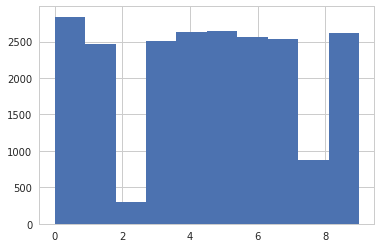

In [515]:
print_clusters(clusters_kmeans_pair, scores_kmeans_pair, vocabulary)

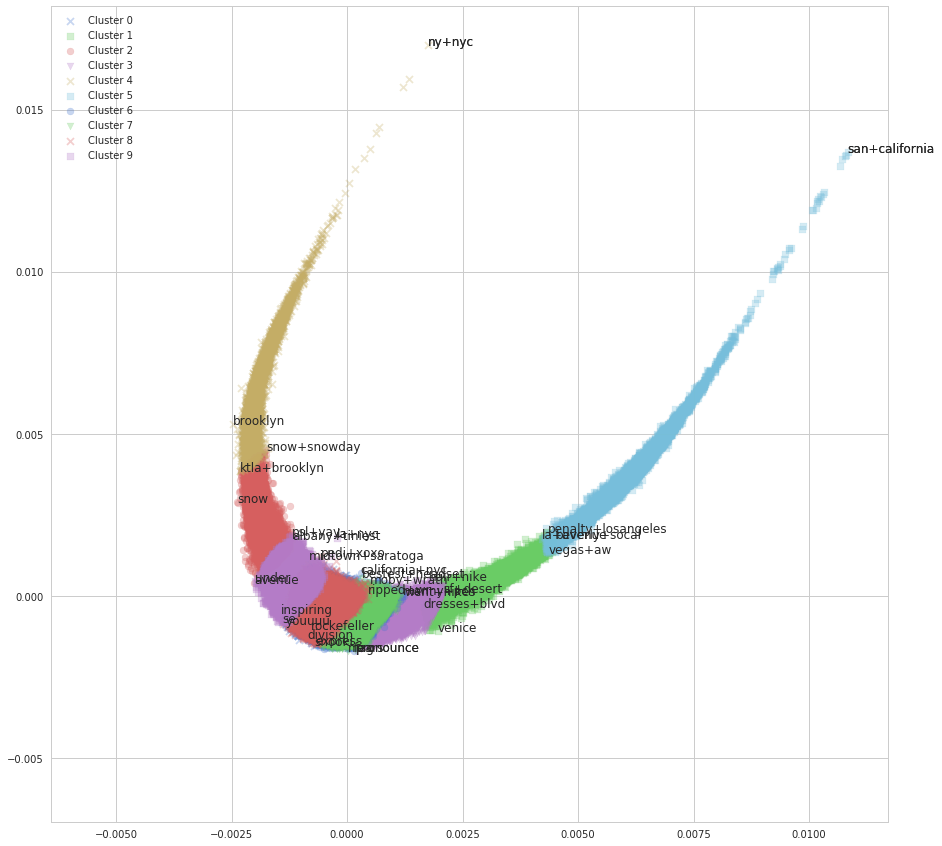

In [516]:
from sklearn.decomposition import PCA
pca = PCA(2)
X_pca = pca.fit_transform(scores_kmeans_pair)

fig, ax = plot_pca(X_pca, clusters_kmeans_pair, vocabulary)
fig.savefig("cluster_pca.png")

(array([39.,  0., 74.,  0.,  1., 57.,  0.,  9., 21., 49.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

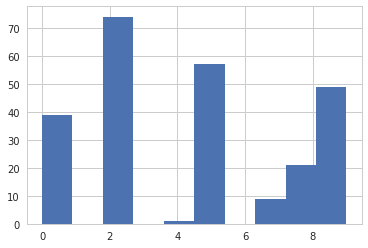

In [377]:
plt.hist(clusters_kmeans_pair[top_z_corr_idx])

## Look at most active words in each unit

In [795]:
def print_unit_top_words(hidden_unit_distrib, k=10):
    unit_sum = np.abs(hidden_unit_distrib).sum(axis=0)
    unit_sorted = np.argsort(unit_sum)[::-1]
    for unit_idx in unit_sorted:
        unit = hidden_unit_distrib[:, unit_idx].flatten()
        print("Unit {:d}".format(unit_idx))
        sort_idx_low = unit.argsort()[:k//2]
        sort_idx_high = unit.argsort()[::-1][:k//2]
        for idx in sort_idx_high:
            print("\t- {:.<30}{:.5f}".format(d.features[idx], unit[idx]))
        print("\t...")
        for idx in sort_idx_low[::-1]:
            print("\t- {:.<30}{:.5f}".format(d.features[idx], unit[idx]))


In [800]:
print_unit_top_words(y_hidden_unit_distrib, k=40)

Unit 30
	- nyc...........................0.04076
	- ny............................0.03372
	- york..........................0.03180
	- brooklyn......................0.02396
	- nj............................0.01822
	- snow..........................0.00196
	- mother........................-0.01118
	- manhattan.....................-0.01192
	- dunkin........................-0.01804
	- jersey........................-0.01865
	- summer........................-0.02006
	- queens........................-0.02417
	- hudson........................-0.02531
	- least.........................-0.02675
	- health........................-0.02721
	- broadway......................-0.02789
	- sandy.........................-0.03041
	- women.........................-0.03232
	- obsessed......................-0.03328
	- nails.........................-0.03419
	...
	- cal...........................-0.14924
	- latimes.......................-0.15099
	- mexican.......................-0.15122
	- las.....................

In [809]:
print_unit_top_words(z_hidden_unit_distrib, k=40)

Unit 2
	- awakens.......................0.01296
	- obamas........................0.01285
	- 116...........................0.01272
	- bjs...........................0.01272
	- sticks........................0.01270
	- outfield......................0.01266
	- whore.........................0.01259
	- leon..........................0.01258
	- weddings......................0.01258
	- collegegameday................0.01256
	- grilled.......................0.01249
	- boundaries....................0.01248
	- choi..........................0.01247
	- plaza.........................0.01245
	- lyrics........................0.01245
	- fixing........................0.01243
	- poised........................0.01243
	- lengths.......................0.01242
	- mozart........................0.01241
	- recurring.....................0.01238
	...
	- hint..........................0.00745
	- longing.......................0.00745
	- jax...........................0.00745
	- springtraining................0.00744
	- c

Look at shared units between Y and Z (the e layer in ABOW)

In [810]:
print_unit_top_words(zws[0], k=40)

Unit 65
	- nyc...........................0.08310
	- ny............................0.07678
	- brooklyn......................0.07454
	- york..........................0.07263
	- nj............................0.06708
	- snow..........................0.06349
	- hudson........................0.04846
	- mother........................0.04779
	- summer........................0.04716
	- manhattan.....................0.04471
	- dunkin........................0.04342
	- obsessed......................0.04330
	- queens........................0.04219
	- least.........................0.04012
	- jersey........................0.03895
	- broadway......................0.03888
	- sandy.........................0.03818
	- women.........................0.03764
	- makeup........................0.03728
	- warm..........................0.03721
	...
	- freeway.......................-0.03543
	- football......................-0.03592
	- bomb..........................-0.03635
	- ucla..........................-0.03748